In [145]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Попробуем применить рассмотренные алгоритмы кластеризации к данным о клиентах некоторой кредитной организации. http://www-bcf.usc.edu/~gareth/ISL/data.html

In [146]:
credit = pd.read_csv('Credit.csv', index_col=0)
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Так как переменная Education, скорее всего категориальная, но коды категорий нам неизвестны, то проведем анализ без нее.

In [147]:
credit.drop('Education', axis=1, inplace=True)

Бинаризуем оставшиеся категориальные переменные.

In [148]:
X = pd.get_dummies(credit)
X.head()

,Income,Limit,Rating,Cards,Age,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,333,1,0,1,0,0,1,0,0,1
2,106.025,6645,483,3,82,903,0,1,0,1,0,1,0,1,0
3,104.593,7075,514,4,71,580,1,0,1,0,1,0,0,1,0
4,148.924,9504,681,3,36,964,0,1,1,0,1,0,0,1,0
5,55.882,4897,357,2,68,331,1,0,1,0,0,1,0,0,1


Для красивого вывода результатов сосздадим две функции Функция pair_plot для визуалициции гистограмм распределний признаков и их попарных разбросов.

In [185]:
def pairplot(X, y=None, colors=None):
    fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

    if y is None:
        y = np.array([0]*X.shape[0])
    unique_y, col_idx = np.unique(y, return_inverse=True)
    if colors is None:
        colors = ['blue']
    colors = np.array(colors)
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if i == j:
                for k, v in enumerate(unique_y):
                    axes[i, j].hist(X.iloc[y == v, i].values, 15, color=colors[k], alpha=0.5)
            else:
                axes[i, j].scatter(X.iloc[:, i].values, X.iloc[:, j].values, c=colors[col_idx], s=8)
            if i == X.shape[1] - 1:
                axes[i, j].set_xlabel(X.columns[j])
            if j == 0:
                axes[i, j].set_ylabel(X.columns[i])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

Функция value_counts для подсчета встречаемости уникальных значений переменных в каждом кластере.

In [158]:
def value_counts(X, y=None):
    for c in X.columns:
        print("---- %s ---" % c)
        if y is None:
            print(X[c].value_counts())
        else:
            print(pd.pivot_table(pd.DataFrame({c: X[c].values, 'cluster': y}), index=[c], columns=['cluster'], aggfunc=len))

Обозначим, какие признаки являются количественными, а какие категориальными.

In [178]:
num_features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Balance']
cat_features = [c for c in credit.columns if not(c in num_features)]

Посомтрим, как выглядят распределения переменных в данных.

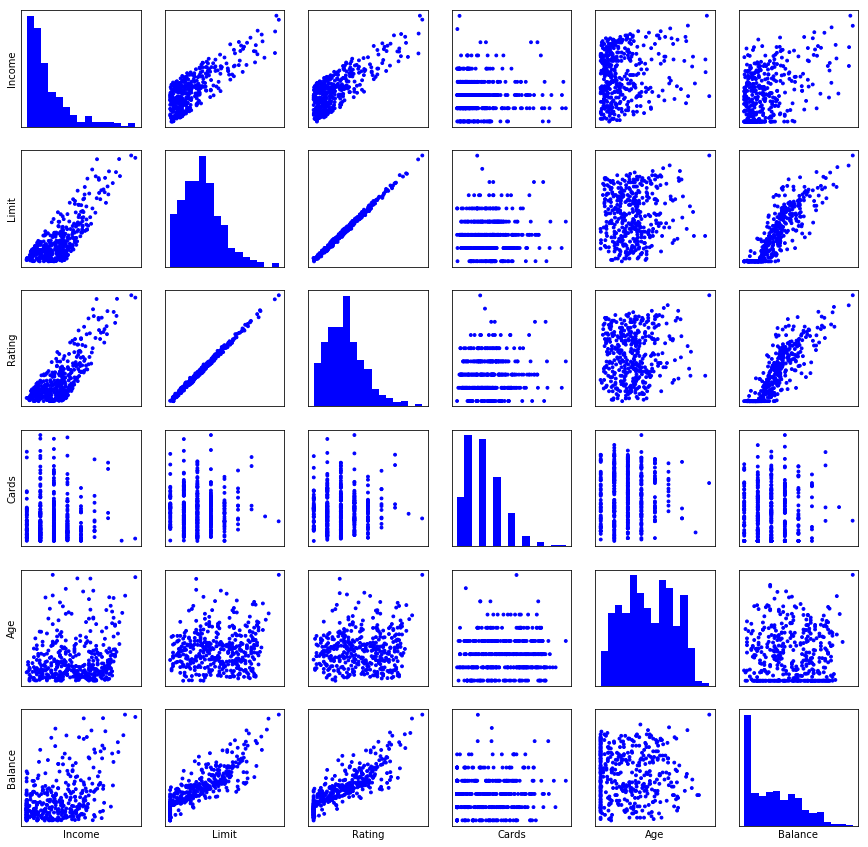

In [180]:
pairplot(credit[num_features])

In [181]:
value_counts(credit[cat_features])

---- Gender ---
Female    207
 Male     193
Name: Gender, dtype: int64
---- Student ---
No     360
Yes     40
Name: Student, dtype: int64
---- Married ---
Yes    245
No     155
Name: Married, dtype: int64
---- Ethnicity ---
Caucasian           199
Asian               102
African American     99
Name: Ethnicity, dtype: int64


Для обучения классификаторов стандартизируем данные.

In [190]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [191]:
X.shape

(400L, 15L)

## K-Means

Для начала попробуем выделить 2 кластера.

In [192]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=10, n_jobs=4, max_iter=1000)
y_pred2 = kmeans2.fit_predict(X)

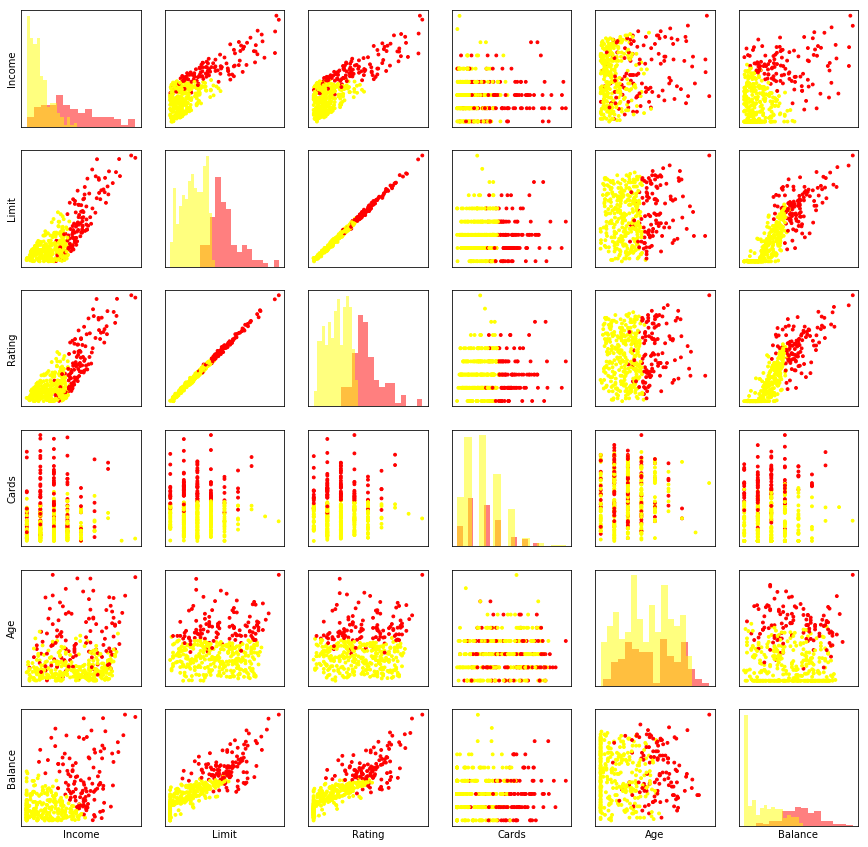

In [193]:
pairplot(credit[num_features], y_pred2, colors=['red', 'yellow'])

In [194]:
value_counts(credit[cat_features], y_pred2)

---- Gender ---
cluster   0    1
Gender          
 Male    55  138
Female   58  149
---- Student ---
cluster   0    1
Student         
No       89  271
Yes      24   16
---- Married ---
cluster   0    1
Married         
No       47  108
Yes      66  179
---- Ethnicity ---
cluster            0    1
Ethnicity                
African American  25   74
Asian             27   75
Caucasian         61  138


В задаче кластеризации отсутствуют метки класса, что существенно осложняет оценку качества кластеризации. В sklearn для этих целей есть две меры: силуэт и Calinski-Harabaz мера.

Создадим функцмю для красивого вывода результатов.

In [195]:
from sklearn.metrics import calinski_harabaz_score, silhouette_samples, silhouette_score
import matplotlib.cm as cm # для выбора цветовой палитры

def estimate_cluster(X, y_pred, name_of_alg=None):
    if not (name_of_alg is None):
        print(("Алгоритм: " + name_of_alg).decode('utf-8'))
    
    # Calinski-Harabaz - Отношение межкластерной дисперсии к внутрикластерной дисперсии
    # Чем больше, тем лучшше
    print("Calinski-Harabaz: %.4f" % calinski_harabaz_score(X, y_pred))

    silhouette_avg = silhouette_score(X, y_pred)
    print("Средний силуэт: %.4f" % silhouette_avg)

    n_clusters = len(np.unique(y_pred))

    # Покажем, как меняются силуэты в каждом кластере
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_xlim([-0.1, 1])
    # 10 здесь необходима для того, чтобы оставлять пространство между силуэтами кластеров
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10
    # пройдем по всем кластерам
    for i in range(n_clusters):
        # Аггрегируем силуеты объетов, попавших в кластер i и сортируем их
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Выводим номер кластера
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Вычисляем новую нижнюю границу между силуетами кластеров
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Силуэты для разных кластеров.".decode('utf-8'))
    ax1.set_xlabel("Величина силуэта".decode('utf-8'))
    ax1.set_ylabel("Номер кластера".decode('utf-8'))

    # Вертикальная линия показывает среднее значение силуэта
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


Алгоритм: K-Means, 2 кластера
Calinski-Harabaz: 69.4211
Средний силуэт: 0.1818
Сумма квадратов расстояний до центров кластера: 5108.8831


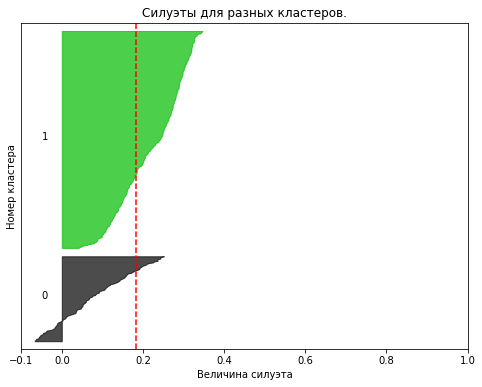

In [196]:
estimate_cluster(X, y_pred2, 'K-Means, 2 кластера')
print("Сумма квадратов расстояний до центров кластера: %.4f" % kmeans2.inertia_)

Как подобрать значение числа кластеров для K-Means? Например, воспользоваться методом локтя.

In [197]:
# обучим K-Means с разным числом кластеров и посмотрим, как менялась сумма квадратов расстояния до центров кластеров
J = []
params = np.arange(1, 20)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=4, max_iter=1000)
    kmeans.fit(X)
    J.append(kmeans.inertia_)
J = np.array(J)

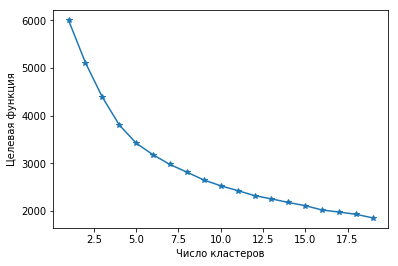

In [198]:
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Целевая функция'.decode('utf-8'))
plt.show()

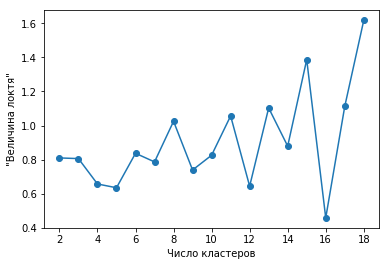

In [199]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('\"Величина локтя\"'.decode('utf-8'))
plt.show()

До 5 значение локтя убывало, а затем начало расти и сущестенно колебаться, поэтому попробуем обучить K-Means с 5 кластерами и посмотрим на результаты.

Алгоритм: K-Means, 5 кластеров
Calinski-Harabaz: 74.4192
Средний силуэт: 0.1817
Сумма квадратов расстояний до центров кластера: 3421.5095


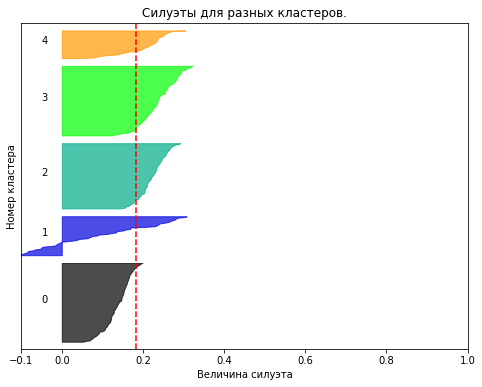

In [200]:
kmeans5 = KMeans(n_clusters=5, random_state=10, n_jobs=4, max_iter=1000)
y_pred5 = kmeans5.fit_predict(X)
estimate_cluster(X, y_pred5, 'K-Means, 5 кластеров')
print("Сумма квадратов расстояний до центров кластера: %.4f" % kmeans5.inertia_)

Средний силуэт не изменился, а вот значение меры Calinski-Harabaz увеличилось, т.е. будем считать, что нам удалось улучшить результаты кластеризации. Посмотрим, какие объекты попадают в разные кластеры.

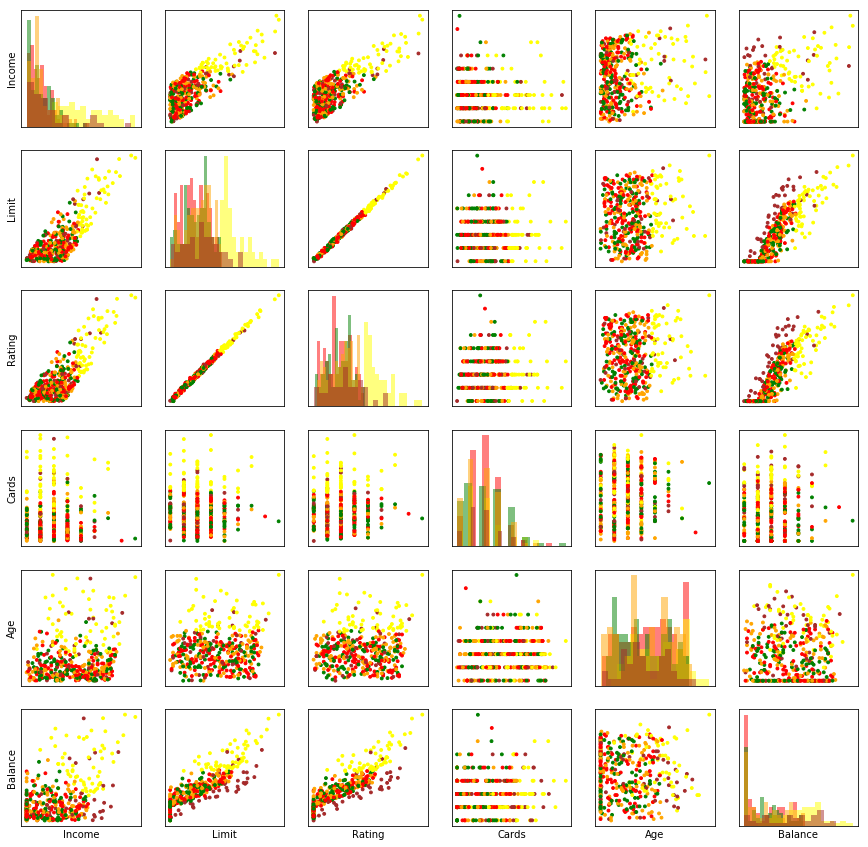

In [202]:
pairplot(credit[num_features], y_pred5, np.array(['red', 'yellow', 'green', 'orange', 'brown']))

In [203]:
value_counts(credit[cat_features], y_pred5)

---- Gender ---
cluster     0     1     2     3     4
Gender                               
 Male    53.0  31.0  93.0   NaN  16.0
Female   59.0  25.0   NaN  99.0  24.0
---- Student ---
cluster      0     1     2     3     4
Student                               
No       112.0  56.0  93.0  99.0   NaN
Yes        NaN   NaN   NaN   NaN  40.0
---- Married ---
cluster      0     1     2     3     4
Married                               
No       112.0  23.0   NaN   NaN  20.0
Yes        NaN  33.0  93.0  99.0  20.0
---- Ethnicity ---
cluster            0   1   2   3   4
Ethnicity                           
African American  34  16  22  17  10
Asian             21  14  24  30  13
Caucasian         57  26  47  52  17


## Аггломеративная кластеризация

В sklearn иерархическая кластеризация представлена только аггломеративной кластеризацией. Можно вырать один из трех критериев объединения двух кластеров в кластер большего размера:
* 'ward' - минимизация дисперсии внутри объединяемых кластеров
* 'average' - минимизация среднего расстояни между парой наблюдений в кластере
* 'complete' - максимальное расстояние между двумя наблюдениями разных кластеров
Применим по очереди все три критерия.

Как известно, для применения иерархической кластеризации необходима матрица попарных расстояний. Если данные структурированы, например, графы, то в качестве аргумента можно передать матрицу связности (connectivity). Если мы не пользуемся ограничениями на связность наблюдений, то достаточно выбрать подходящую меру расстояния (affinity) и попарные расстояния будут рассчитаны методом самостоятельно. В примерах ниже мы используем евклидово расстояние.
Как и для алгоритма K-Means, необходимо выбрать число кластеров.

### Ward

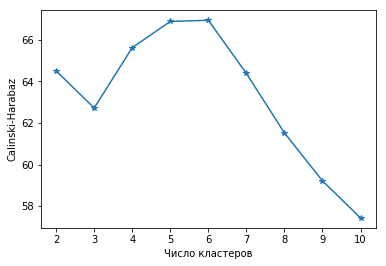

In [204]:
from sklearn.cluster import AgglomerativeClustering

J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean') 
    # Далее будем опускать affinity='euclidean', так как это значение по умолчанию
    ward_arc.fit(X)
    J.append(calinski_harabaz_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

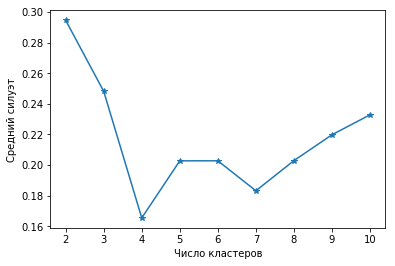

In [205]:
J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ward_arc.fit(X)
    J.append(silhouette_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Обе меры имеют высокое значение при разбиении на 2 кластера. Посмотрим, что в этом случае получается.

Алгоритм: Ward, 2 кластера
Calinski-Harabaz: 64.5112
Средний силуэт: 0.2946


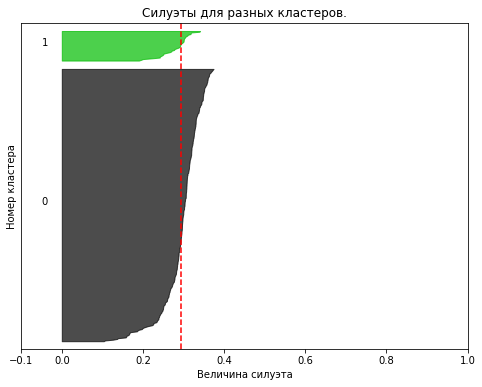

In [206]:
ward_agc = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_ward2 = ward_agc.fit_predict(X)
estimate_cluster(X, y_ward2, 'Ward, 2 кластера')

По сравнению с k-Means мы улучшили результаты по среднему силуэту, но ухудшили по другой мере.

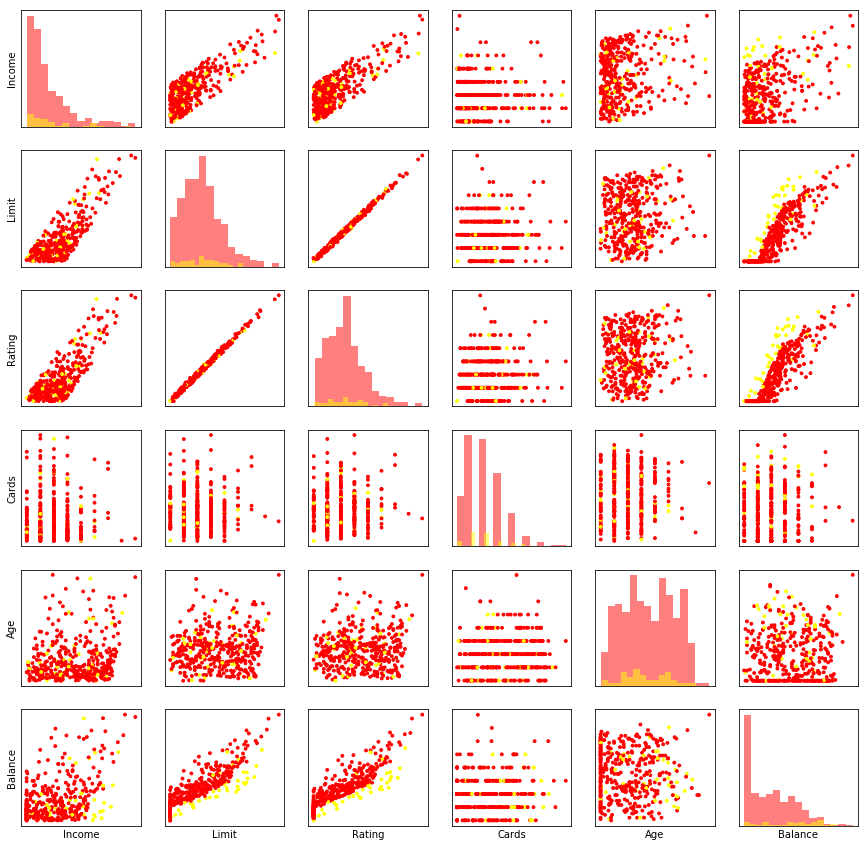

In [207]:
pairplot(credit[num_features], y_ward2, np.array(['red', 'yellow']))

In [208]:
value_counts(credit[cat_features], y_ward2)

---- Gender ---
cluster    0   1
Gender          
 Male    177  16
Female   183  24
---- Student ---
cluster      0     1
Student             
No       360.0   NaN
Yes        NaN  40.0
---- Married ---
cluster    0   1
Married         
No       135  20
Yes      225  20
---- Ethnicity ---
cluster             0   1
Ethnicity                
African American   89  10
Asian              89  13
Caucasian         182  17


Сделаем все то же самое для других критериев аггломеративной кластеризации.

### Average

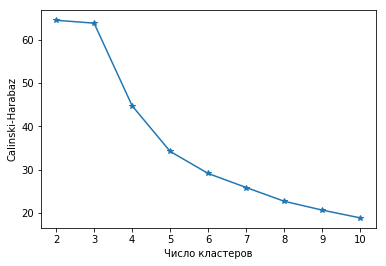

In [209]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(calinski_harabaz_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

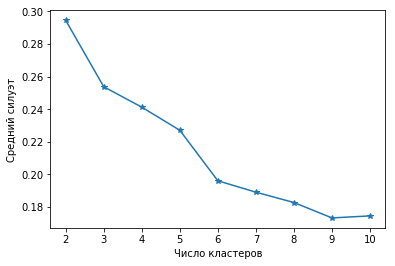

In [210]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(silhouette_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Обе меры с ростом числа кластеров убывают. Так как начиная с 3 Calinski_Harabaz начинает резко убывать, попробуем разбить на 3 кластера.

Алгоритм: Average, 3 кластера
Calinski-Harabaz: 63.8346
Средний силуэт: 0.2538


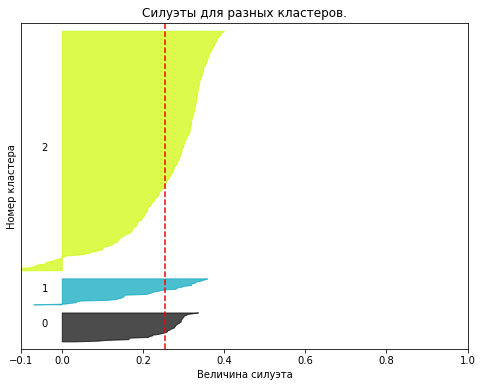

In [211]:
average_agc = AgglomerativeClustering(n_clusters=3, linkage='average', compute_full_tree=True)
y_average3 = average_agc.fit_predict(X)
estimate_cluster(X, y_average3, 'Average, 3 кластера')

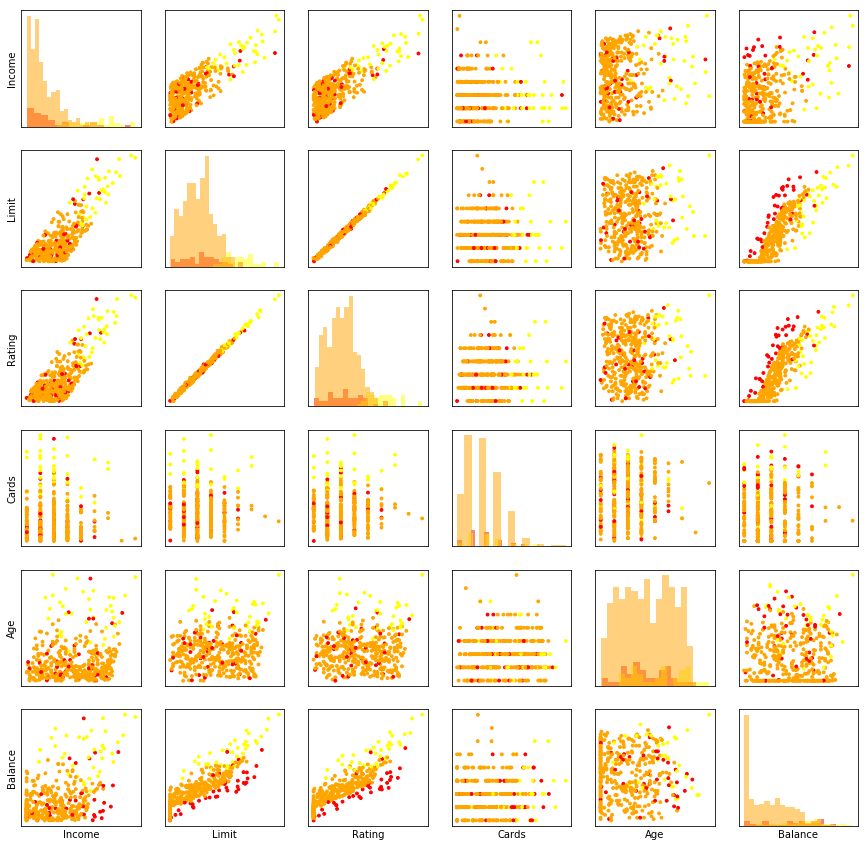

In [212]:
pairplot(credit[num_features], y_average3, np.array(['red', 'yellow', 'orange']))

In [213]:
value_counts(credit[cat_features], y_average3)

---- Gender ---
cluster   0   1    2
Gender              
 Male    16  20  157
Female   24  16  167
---- Student ---
cluster     0     1      2
Student                   
No        NaN  36.0  324.0
Yes      40.0   NaN    NaN
---- Married ---
cluster   0   1    2
Married             
No       20  15  120
Yes      20  21  204
---- Ethnicity ---
cluster            0   1    2
Ethnicity                    
African American  10  13   76
Asian             13   7   82
Caucasian         17  16  166


### Complete

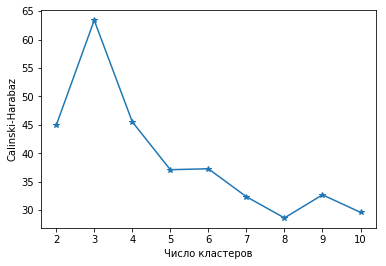

In [214]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(calinski_harabaz_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

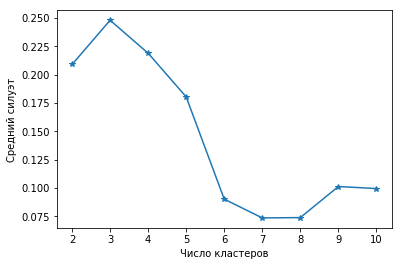

In [215]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(silhouette_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Начиная с 3 кластеров, обе меры начинают стремительно убывать.

Алгоритм: Complete, 3 кластера
Calinski-Harabaz: 63.3899
Средний силуэт: 0.2479


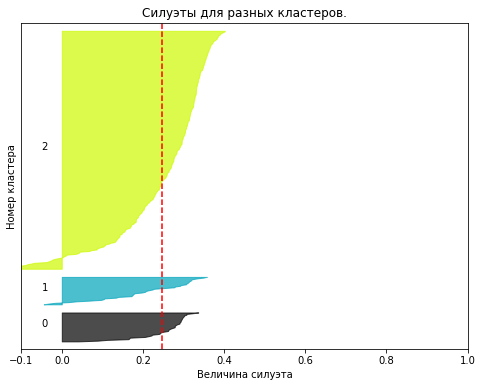

In [216]:
complete_agc = AgglomerativeClustering(n_clusters=3, linkage='complete', compute_full_tree=True)
y_complete3 = complete_agc.fit_predict(X)
estimate_cluster(X, y_complete3, 'Complete, 3 кластера')

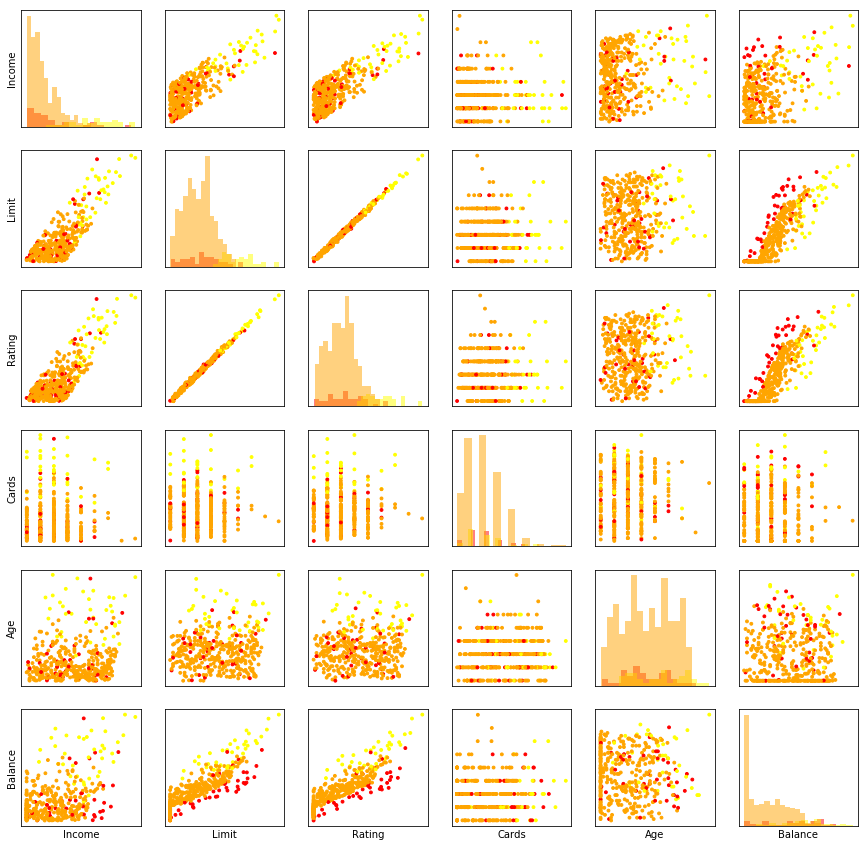

In [217]:
pairplot(credit[num_features], y_complete3, np.array(['red', 'yellow', 'orange']))

In [218]:
value_counts(credit[cat_features], y_complete3)

---- Gender ---
cluster   0   1    2
Gender              
 Male    16  26  151
Female   24  12  171
---- Student ---
cluster     0     1      2
Student                   
No        NaN  38.0  322.0
Yes      40.0   NaN    NaN
---- Married ---
cluster   0   1    2
Married             
No       20  17  118
Yes      20  21  204
---- Ethnicity ---
cluster            0   1    2
Ethnicity                    
African American  10   9   80
Asian             13  12   77
Caucasian         17  17  165


### Иерархическая кластеризация в SciPy

К сожалению, в sklearn есть возможность посмотреть на порядок объединения более мелких кластеров в более крупные, но без учета расстояния между ними. Но эта возможность есть в пакете SciPy. Также в sklearn отсутствует возможность оценки кофенетической корееляции. Ниже приведен пример, как это сдлеать для критерия 'ward' и евклидова расстояния в SciPy.

Документация: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

Тьюториал: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [219]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(X, method='ward', metric='euclidean') # объект для дендрограммы

c, coph_dists = cophenet(Z, pdist(X))
c

0.6752435350970234

Каждая строка Z имеет формат [idx1, idx2, dist, sample_count].

In [96]:
Z[0]

array([ 125.        ,  167.        ,    0.23009411,    2.        ])

На первом шаге алгоритм решил объединить кластеры с номерами 125 и 167 (объекты) и расстояние между ними равно 0.23, в результате получили кластер, содержащий 2 объекта с номером X.shape[0], так как номер с 0 по X.shape[0]-1 соответствуют номерам объектов. В нашем случае, этот кластер получил индекс 400.

In [220]:
np.set_printoptions(precision=5, suppress=True)
Z[:20]

array([[ 125.     ,  167.     ,    0.23009,    2.     ],
       [ 143.     ,  362.     ,    0.23833,    2.     ],
       [ 175.     ,  247.     ,    0.24269,    2.     ],
       [  30.     ,  269.     ,    0.25381,    2.     ],
       [ 296.     ,  302.     ,    0.2582 ,    2.     ],
       [ 146.     ,  311.     ,    0.31344,    2.     ],
       [ 147.     ,  377.     ,    0.32025,    2.     ],
       [ 124.     ,  400.     ,    0.37593,    3.     ],
       [  54.     ,  285.     ,    0.38542,    2.     ],
       [ 138.     ,  148.     ,    0.38718,    2.     ],
       [ 208.     ,  255.     ,    0.40331,    2.     ],
       [ 366.     ,  369.     ,    0.40631,    2.     ],
       [  20.     ,  246.     ,    0.41838,    2.     ],
       [ 131.     ,  149.     ,    0.42113,    2.     ],
       [ 321.     ,  335.     ,    0.42636,    2.     ],
       [ 264.     ,  300.     ,    0.45598,    2.     ],
       [  18.     ,   43.     ,    0.46963,    2.     ],
       [  55.     ,  120.     ,

На восьмом шаге впервые происходит объединение сформированного кластера с объектом. Объединяются кластер с индексом 400 и объект 124. Посмотрим на значения признаков, попавших в кластер.

In [221]:
credit.iloc[[125, 167, 124], :]

,Income,Limit,Rating,Cards,Age,Gender,Student,Married,Ethnicity,Balance
126,27.578,2531,195,1,34,Female,No,Yes,Caucasian,0
168,29.403,2327,178,1,37,Female,No,Yes,Caucasian,0
125,29.564,2529,192,1,30,Female,No,Yes,Caucasian,0


Построим дендрограмму.

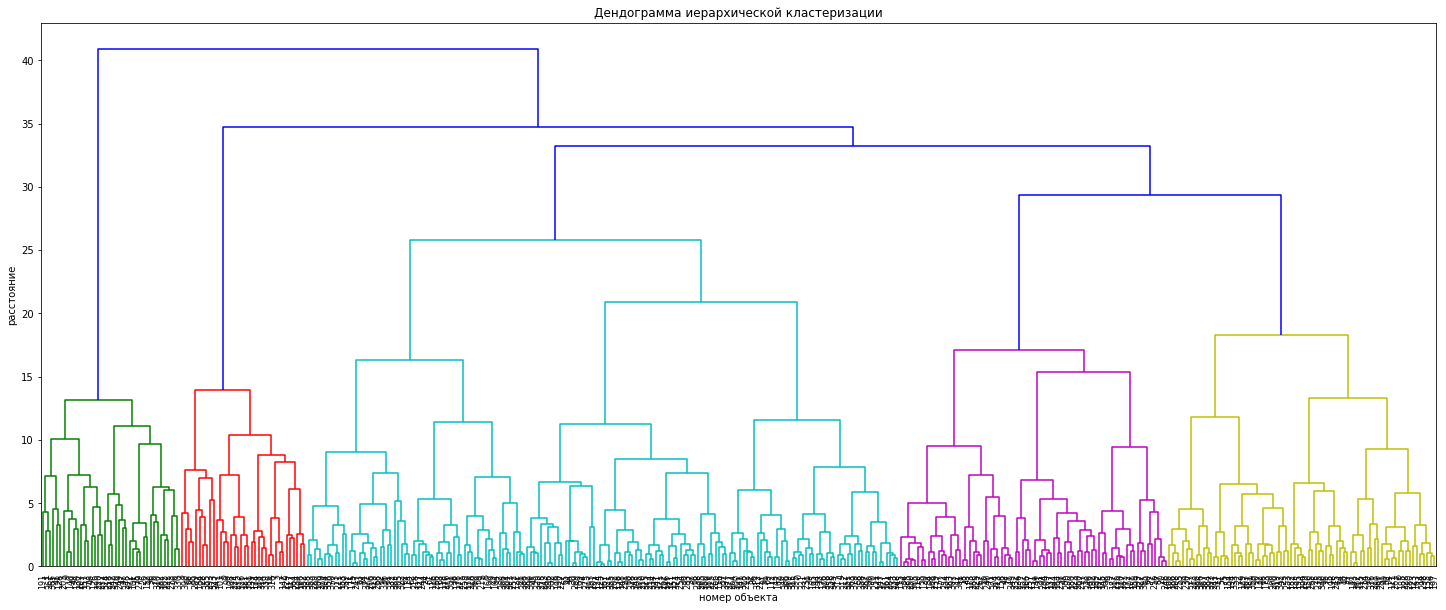

In [222]:
plt.figure(figsize=(25, 10))
plt.title('Дендограмма иерархической кластеризации'.decode('utf-8'))
plt.xlabel('номер объекта'.decode('utf-8'))
plt.ylabel('расстояние'.decode('utf-8'))
dendrogram(
    Z,
    leaf_rotation=90.,  # повернуть подписи меток на 90 градусов
    leaf_font_size=8.,  # размер подписе на оси x
)
plt.show()

Получилось громоздко, но можно сократить, исключив мелкие кластеры.

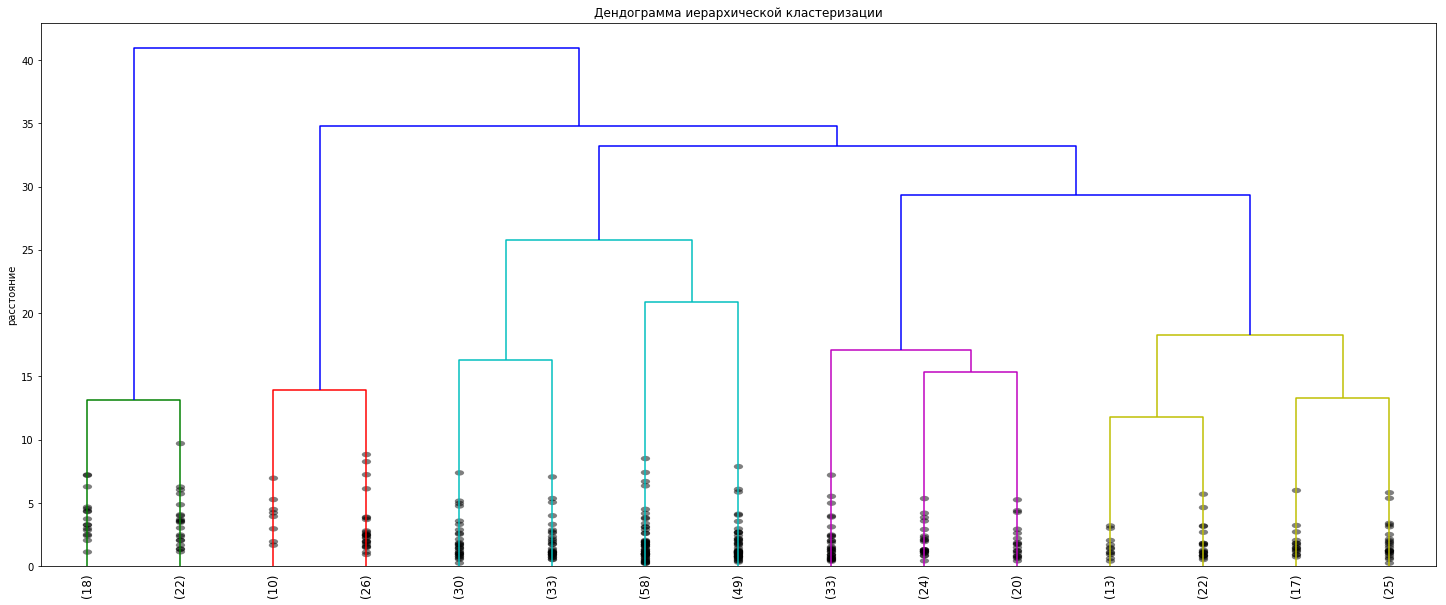

In [224]:
plt.figure(figsize=(25, 10))
plt.title('Дендограмма иерархической кластеризации'.decode('utf-8'))
plt.ylabel('расстояние'.decode('utf-8'))
dendrogram(
    Z,
    truncate_mode='lastp',  # показать только последние p кластеров
    p=15,  # число кластеров для показа
    show_leaf_counts=True,  # показывать чило объектов в листах
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # показать распределения в сжатых ветвях
)
plt.show()

Если необходимо виидеть значения целевого показателя в кластерах и выбирать пороговое значение критерия для определения числа кластеров, можно воспользоваться функцией ниже (оригинал: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

In [225]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

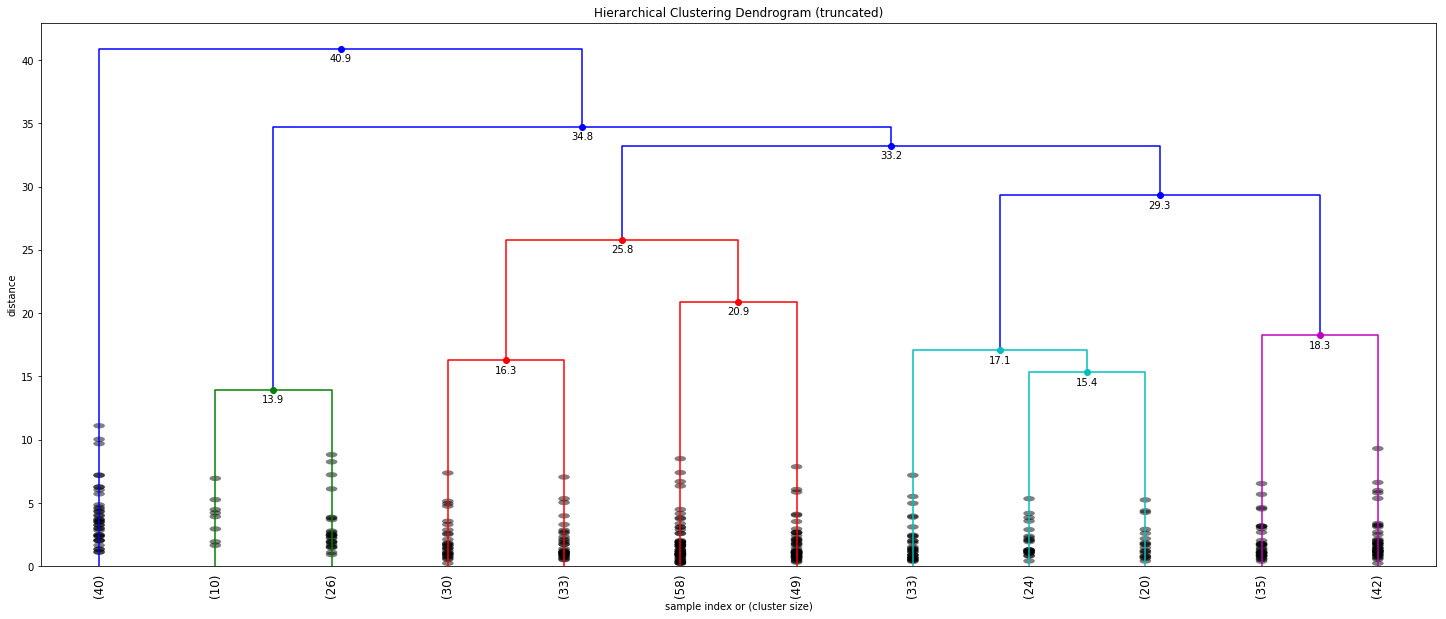

In [226]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=2,  # минимальное значение меры, при которой стоит указывать ее значение
)
plt.show()

Сейчас самим алгоритмом предлагается выделить 5 кластеров (подсвечены цветами). Можно их изменить, задав проговое расстояние.

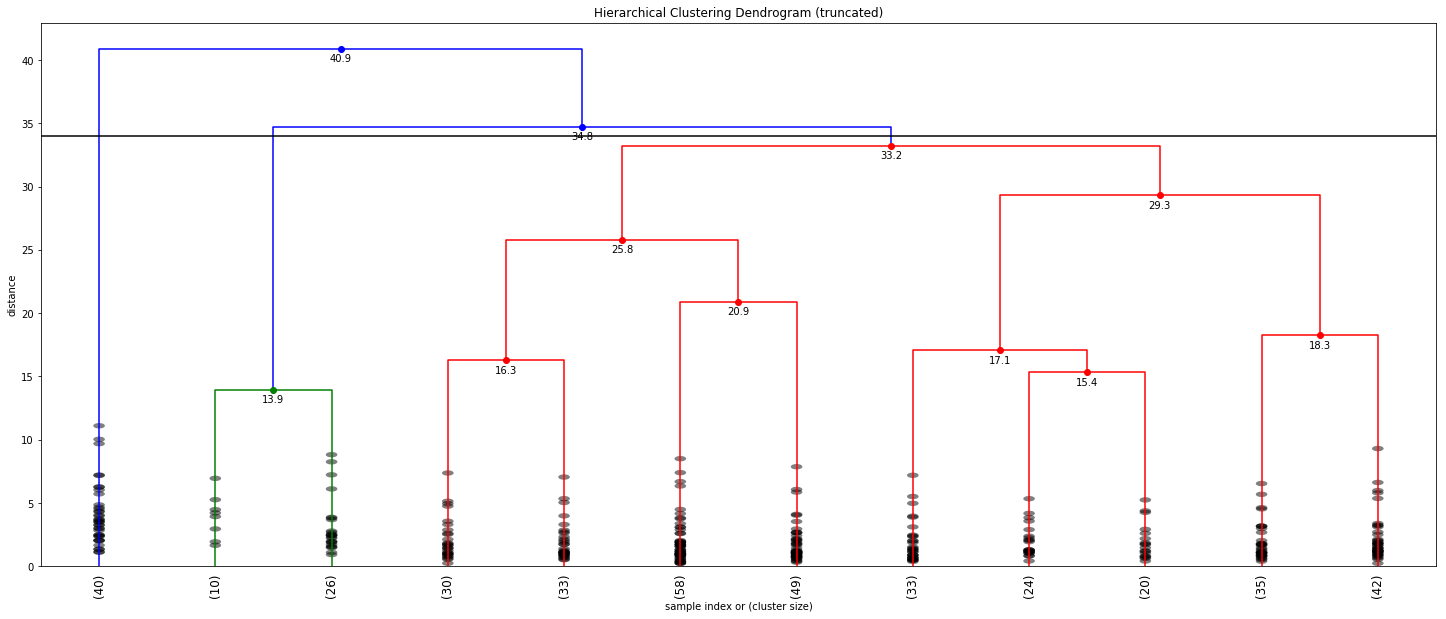

In [227]:
max_d = 34
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)
plt.show()

### DBSCAN

Код для визуализации является модификацией кода: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

Оценка числа кластеров: 21


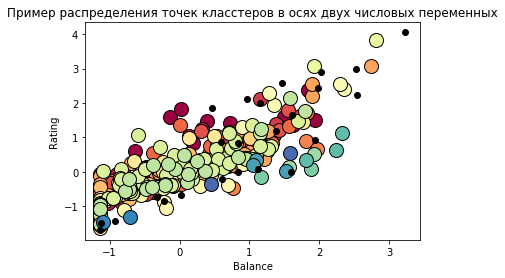

In [230]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2.8, min_samples=2, metric='euclidean').fit(X)
                                                                
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # создаем массив 0 таких же размеров, как и массив меток кластеров
core_samples_mask[db.core_sample_indices_] = True # массив индикаторов "внутренних точек" кластеров
labels = db.labels_

# Подсчет числа кластеров за исключением шумов.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Оценка числа кластеров: %d' % n_clusters_)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] # Палетка цветов не должна включать черный.


for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный спользуем для выбросов.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy_core = X[class_member_mask & core_samples_mask]
    xy_not_core = X[class_member_mask & ~core_samples_mask]

    plt.plot(xy_core[:, 5], xy_core[:, 2], 'o', markerfacecolor=tuple(col), 
             markeredgecolor='k', markersize=14)
    plt.plot(xy_not_core[:, 5], xy_not_core[:, 2], 'o', markerfacecolor=tuple(col), 
             markeredgecolor='k', markersize=6)
plt.xlabel(num_features[5])
plt.ylabel(num_features[2])
plt.title('Пример распределения точек класстеров в осях двух числовых переменных'.decode('utf-8'))
plt.show()

Алгоритм: DBSCAN, eps=2.8, min_samples=2
Calinski-Harabaz: 28.2423
Средний силуэт: 0.2506


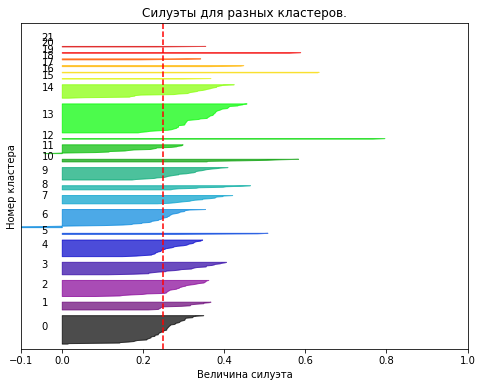

In [231]:
estimate_cluster(X, labels, 'DBSCAN, eps=2.8, min_samples=2')

Чтобы понять, как изменяется число выделяемых кластеров в зависимости от параметров eps и min_samples, можно оценить число кластеров на решетке значений, а также средний силуэт и меру Calinski-Harabaz.

In [236]:
eps_values = np.arange(0.1, 3, 0.1)
min_sample_values = np.arange(2, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))
silhouette = np.zeros(((len(eps_values)), len(min_sample_values)))
calinski = np.zeros(((len(eps_values)), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_cluster_estimates[i, j] > 1:
            silhouette[i, j] = silhouette_score(X, db.labels_)
            calinski[i, j] = calinski_harabaz_score(X, db.labels_)

In [237]:
eps_values = np.arange(0.1, 3, 0.1)
min_sample_values = np.arange(2, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

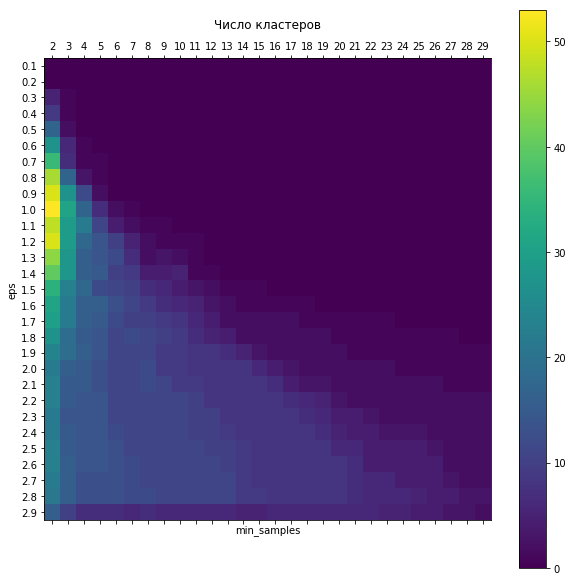

In [238]:
plt.figure(figsize=(10,10))        
plt.matshow(n_cluster_estimates, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Число кластеров'.decode('utf-8'))
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

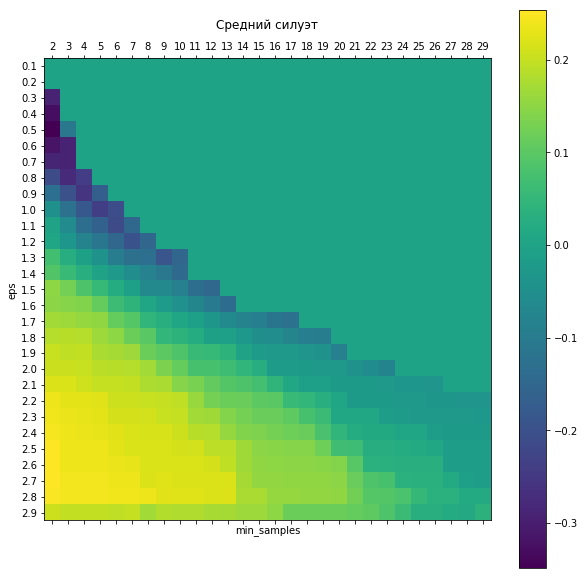

In [239]:
plt.figure(figsize=(10,10))        
plt.matshow(silhouette, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Средний силуэт'.decode('utf-8'))
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

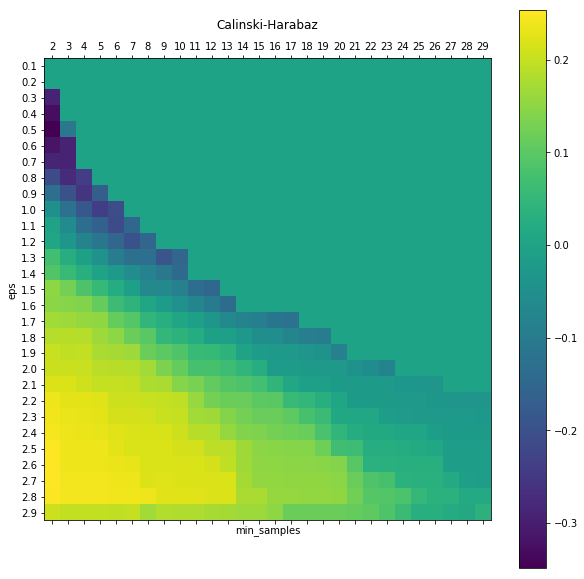

In [240]:
plt.figure(figsize=(10,10))        
plt.matshow(silhouette, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Calinski-Harabaz'.decode('utf-8'))
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

### Спектральная кластеризация

Так как спектральная кластеризация - кластеризация на графах, небходимо для имеющихся объектов построить граф сходства. В sklearn можно не делать этого самостоятельно, а лишь выбрать способ его определения (affinity). Самая простая связывать только самые близкие по евклидовой мере объекты.

In [241]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4).fit(X)
y_spectral_nn3 = spectral.labels_

Алгоритм: Спектральная кластеризация (nn), 3 кластера
Calinski-Harabaz: 38.8082
Средний силуэт: 0.0440


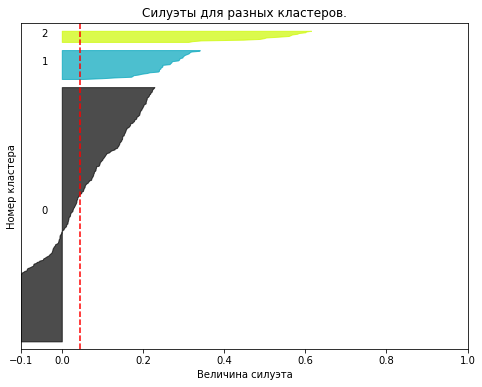

In [242]:
estimate_cluster(X, y_spectral_nn3, 'Спектральная кластеризация (nn), 3 кластера')

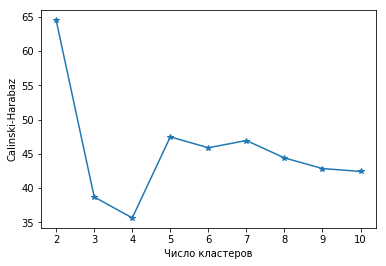

In [243]:
J = []
params = np.arange(2, 11)
for k in params:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4)
    spectral.fit(X)
    J.append(calinski_harabaz_score(X, spectral.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

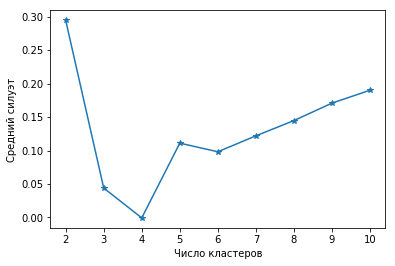

In [244]:
J = []
params = np.arange(2, 11)
for k in params:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4)
    spectral.fit(X)
    J.append(silhouette_score(X, spectral.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Алгоритм: Спектральная кластеризация (nn), 5 кластеров
Calinski-Harabaz: 50.8467
Средний силуэт: 0.1290


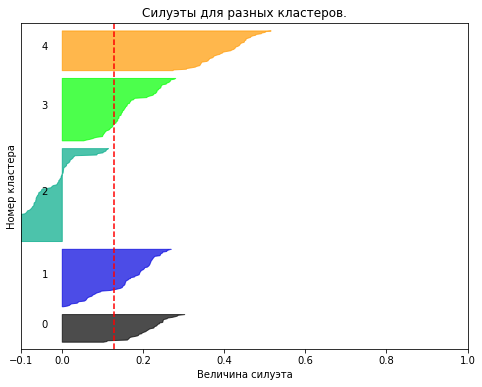

In [246]:
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4).fit(X)
y_spectral_nn5 = spectral.labels_
estimate_cluster(X, y_spectral_nn5, 'Спектральная кластеризация (nn), 5 кластеров')

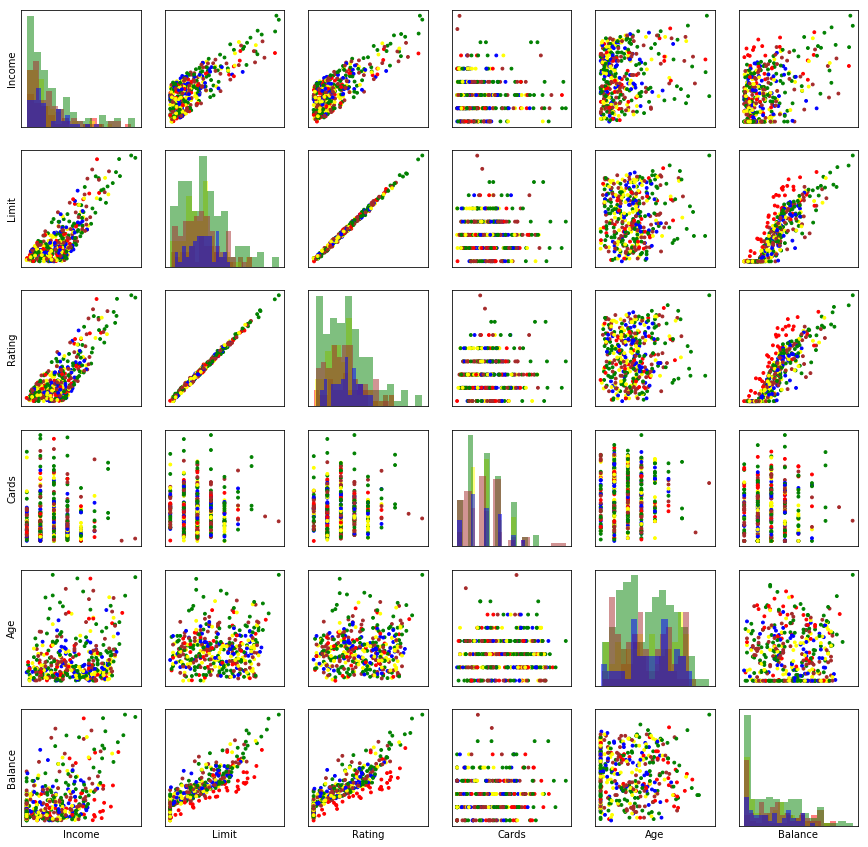

In [249]:
pairplot(credit[num_features], y_spectral_nn5, np.array(['red', 'yellow', 'green', 'brown', 'blue']))

In [250]:
value_counts(credit[cat_features], y_spectral_nn2)

---- Gender ---
cluster     0     1     2     3     4
Gender                               
 Male    89.0  46.0  16.0   NaN  42.0
Female    NaN  86.0  24.0  57.0  40.0
---- Student ---
cluster     0      1     2     3     4
Student                               
No       89.0  132.0   NaN  57.0  82.0
Yes       NaN    NaN  40.0   NaN   NaN
---- Married ---
cluster     0     1     2     3     4
Married                              
No       33.0  62.0  20.0   NaN  40.0
Yes      56.0  70.0  20.0  57.0  42.0
---- Ethnicity ---
cluster              0     1     2     3     4
Ethnicity                                     
African American   NaN   7.0  10.0   NaN  82.0
Asian              NaN  89.0  13.0   NaN   NaN
Caucasian         89.0  36.0  17.0  57.0   NaN


Другой пример, для определения сходства использовать Гауссовское ядро.

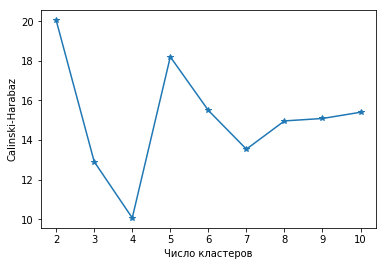

In [251]:
J = []
params = np.arange(2, 11)
for k in params:
    spectral = SpectralClustering(n_clusters=k, affinity='rbf', n_jobs=4)
    spectral.fit(X)
    J.append(calinski_harabaz_score(X, spectral.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

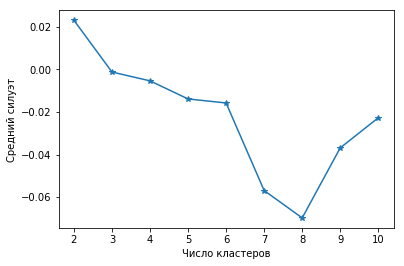

In [252]:
J = []
params = np.arange(2, 11)
for k in params:
    spectral = SpectralClustering(n_clusters=k, affinity='rbf', n_jobs=4)
    spectral.fit(X)
    J.append(silhouette_score(X, spectral.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Получили очень плохие значения среднего силуэта, т.е. в данном случае Гауссово ядро не подходит для описания структуры данных.